In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization, \
                Activation, MaxPooling2D, ReLU, Dense, UpSampling2D, concatenate, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16,MobileNetV2,ResNet50,DenseNet121
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import os
import cv2
import glob
import sys
import random
from prettytable import PrettyTable
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import zipfile

2024-04-23 00:18:14.157171: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# with zipfile.ZipFile('Training_data/ATLAS_2.0_Middle.zip', 'r') as zip_ref:
#     zip_ref.extractall('Training_data/')
#     zip_ref.close()

In [3]:
def progressbar(n_step, n_total):
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [4]:
def plot_image(image, label):
    # Render
    fig, axes = plt.subplots(1,3, figsize=(16,4))
    image, label = image.squeeze(), label.squeeze()

    # Plot MRI image
    axes.flat[0].imshow(image, cmap='gray')
    axes.flat[0].set_title('MRI Slice')
    axes.flat[1].imshow(label, cmap='gray')
    axes.flat[1].set_title('Ground Truth')

    # Plot infarct area
    axes.flat[2].imshow(image, cmap='gray')
    axes.flat[2].set_title('Infarct Area')
    axes.flat[2].imshow(label, cmap='inferno', alpha=0.3)

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_curve(unet_history, vgg16_unet_history, resnet_unet_history, mobile_unet_history, dense_unet_history):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten axes array to simplify iteration
    axes = axes.flatten()

    # Plot accuracy
    axes[0].plot(unet_history.history['accuracy'], label='UNet')
    axes[0].plot(vgg16_unet_history.history['accuracy'], label='VGG16-UNet')
    axes[0].plot(resnet_unet_history.history['accuracy'], label='ResNet-UNet')
    axes[0].plot(mobile_unet_history.history['accuracy'], label='MobileNet-UNet')
    axes[0].plot(dense_unet_history.history['accuracy'], label='DenseNet-UNet')
    axes[0].legend()
    axes[0].set_title('Trace Plot of Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')

    # Plot validation accuracy
    axes[1].plot(unet_history.history['val_accuracy'], label='UNet')
    axes[1].plot(vgg16_unet_history.history['val_accuracy'], label='VGG16-UNet')
    axes[1].plot(resnet_unet_history.history['val_accuracy'], label='ResNet-UNet')
    axes[1].plot(mobile_unet_history.history['val_accuracy'], label='MobileNet-UNet')
    axes[1].plot(dense_unet_history.history['val_accuracy'], label='DenseNet-UNet')
    axes[1].legend()
    axes[1].set_title('Trace Plot of Valid Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')

    # Plot loss
    axes[2].plot(unet_history.history['loss'], label='UNet')
    axes[2].plot(vgg16_unet_history.history['loss'], label='VGG16-UNet')
    axes[2].plot(resnet_unet_history.history['loss'], label='ResNet-UNet')
    axes[2].plot(mobile_unet_history.history['loss'], label='MobileNet-UNet')
    axes[2].plot(dense_unet_history.history['loss'], label='DenseNet-UNet')
    axes[2].legend()
    axes[2].set_title('Trace Plot of Loss')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')

    # Plot validation loss
    axes[3].plot(unet_history.history['val_loss'], label='UNet')
    axes[3].plot(vgg16_unet_history.history['val_loss'], label='VGG16-UNet')
    axes[3].plot(resnet_unet_history.history['val_loss'], label='ResNet-UNet')
    axes[3].plot(mobile_unet_history.history['val_loss'], label='MobileNet-UNet')
    axes[3].plot(dense_unet_history.history['val_loss'], label='DenseNet-UNet')
    axes[3].legend()
    axes[3].set_title('Trace Plot of Valid Loss')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Loss')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [6]:
def load_nii(image_path, label_path):
    image = nib.load(image_path).get_fdata()
    label = nib.load(label_path).get_fdata()
    return image, label

In [7]:
def data_select(threshold, images, labels):
    index = []
    for i in range (labels.shape[0]):
        if np.count_nonzero(labels[i, :, :]) >= threshold:
            index.append(i)

    # Select images, labels by index calculated from threshold
    selected_images = images[index]
    selected_labels = labels[index]
    return selected_images, selected_labels

In [8]:
def get_dataset(data_folder, data_num, start_index):
    # Store MR images and masks
    images, labels = [], []

    # Add path of images recursively
    target_path = os.path.join(data_folder, "**/*_T1w.nii.gz")
    image_files = sorted(glob.glob(target_path, recursive=True)) # sorted alphabetically.

    # Set the uppder bound
    end_index = start_index + data_num

    # Select data from start to end index
    index = np.arange(start_index, end_index)
    image_files=[image_files[i] for i in index]

    # Load images and labels
    for image_path in image_files:
        label_path = image_path.replace('_T1w.nii.gz', '_label-L_desc-T1lesion_mask.nii.gz')
        image, label = load_nii(image_path, label_path)
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [9]:
def resize(target_data, target_shape, mode='label'):
    resized_list = []
    for _, data in enumerate(target_data):  # Loop for Batch
        for d in range(data.shape[2]):      # Loop for Depth
            # Resize each 2D slice to the target shape
            resized_data = cv2.resize(data[:, :, d], target_shape, interpolation=cv2.INTER_NEAREST)
            # Normalize pixles into 0 to 1
            if mode == 'image':
                resized_data /= 255.
            # Expand the gray channel
            resized_data = np.expand_dims(resized_data, axis=2)

            resized_list.append(resized_data)
    return np.array(resized_list)

In [10]:
# Define data path
data_folder = "Training_data"

# Define retrieved data for each iteration
num_data = 5

# Define iterations
num_iter = 20

# Define resize shape
target_shape = (256, 256)
images, labels = None, None

print('Data Loading:')
for i in range (num_iter):
    #
    mri_data, mri_mark = get_dataset(data_folder, num_data, i*num_data)

    # Resize the 3D MRI image
    resized_images = resize(mri_data, target_shape, 'image')
    resized_labels = resize(mri_mark, target_shape, 'label')

    # Select slices with labels >= 100
    select_images, select_labels = data_select(100, resized_images, resized_labels)

    # Stack data iteratively
    if i == 0:
        images = select_images
        labels = select_labels
    else:
        images = np.vstack((select_images, images))
        labels = np.vstack((select_labels, labels))

    # Release the memory for the next iteration
    progressbar(i, num_iter)

Data Loading:
 [==================================================] 20/20 Done...



In [50]:
print('Pre-processed MRI data:')
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)
print('Values of images\n',  images[0, 5:10, 5:10, 0])
print('Check labels (only 0 or 1 as value):', np.argmax(np.sum(np.logical_and(resized_labels != 0, resized_labels != 1), axis=(1, 2)))) # 0 output = only contains 0 and 1
print('Max-Min range for 1st image:',  np.min(resized_images[0, :, :, 0]), '/', np.max(resized_images[0, :, :, 0]))

Pre-processed MRI data:
Shape of images: (4958, 256, 256, 1)
Shape of labels: (4958, 256, 256, 1)
Values of images
 [[0.0067541  0.00541983 0.00568668 0.00595354 0.00515297]
 [0.00595354 0.00622039 0.0067541  0.00541983 0.00568668]
 [0.00568668 0.00595354 0.00568668 0.00648725 0.00541983]
 [0.00515297 0.00622039 0.00515297 0.00541983 0.00488612]
 [0.00515297 0.00622039 0.00515297 0.00541983 0.00488612]]
Check labels (only 0 or 1 as value): 0
Max-Min range for 1st image: 0.0 / 0.4526675953584559


#### **1.2 Plot pre-processed data**

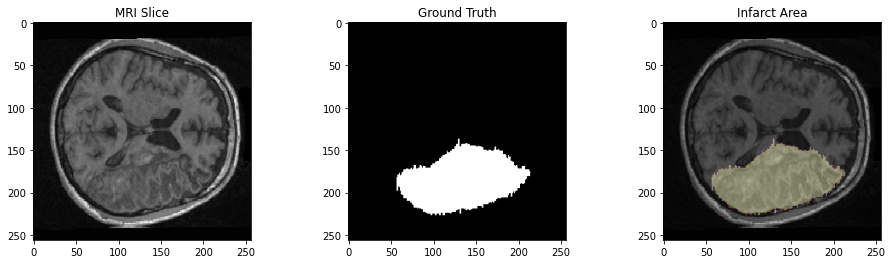

In [51]:
# Plot a slice with the max number of label 1
index = np.argmax(np.sum(labels == 1, axis=(1, 2)))
plot_image(images[index], labels[index])

In [52]:
# Seperate datasets as training and testing with 8:2
X, X_test, y, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [53]:
print('Shapes for training and testing sets')
print('X:', X.shape)
print('y:', y.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Shapes for training and testing sets
X: (3966, 256, 256, 1)
y: (3966, 256, 256, 1)
X_test: (992, 256, 256, 1)
y_test: (992, 256, 256, 1)


In [15]:
# You could load trained models and history data for skipping Section 2: Build and Train U-Net and VGG16-UNET Models
# unet = load_model('model/unet.h5')
# unet_history = np.load('data/unet_histroy.npy', allow_pickle=True).item()
# vgg16_unet = load_model('model/vgg16_unet.h5')
# vgg16_unet_history = np.load('data/vgg16_unet_histroy.npy', allow_pickle=True).item()

In [16]:
from tensorflow.keras.losses import Loss

class BinarFocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0, name='binarfocal_loss'):
        super(BinarFocalLoss, self).__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = self.alpha * y_true + (1 - self.alpha) * (1 - y_true)
        loss = - alpha_t * tf.math.pow(1.0 - pt, self.gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)

In [17]:
from keras.losses import binary_crossentropy
class UNet:
    # UNet architecture for image segmentation
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build the downsample block 2 Conv2D, BatchNorm, and ReLU layers
    def downsample_block(self, inputs, units=32, kernel_size = 3, pool_size=2):

        h = Conv2D(units, kernel_size, padding='same')(inputs)
        h = BatchNormalization()(h)
        h = ReLU()(h)

        h = Conv2D(units, kernel_size, padding='same')(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)

        pooling = MaxPooling2D(pool_size=pool_size)(h)
        return h, pooling

    # Build the upsample block 2 Conv2D, BatchNorm, and ReLU layers
    def upsample_block(self, inputs, skip_connections, units=32, kernel_size = 3, upsample_size=2):
        # Upsample the input tensor
        upsample = UpSampling2D(size=upsample_size)(inputs)

        # Skip connections from the corresponding downsample block.
        h = concatenate([upsample, skip_connections], axis=-1)

        # Convolutional layer followed by batch normalization and ReLU activation
        h = Conv2D(units, kernel_size, padding='same')(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)

        # Convolutional layer followed by batch normalization and ReLU activation
        h = Conv2D(units, kernel_size, padding='same')(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)

        return h

    # Network Contruction
    def build(self, kernel_base):
        # Define the input shape
        inputs = Input(shape = self.input_shape)
        
        # Build 4 blocks for downsampling
        conv1, pool1 = self.downsample_block(inputs, 1*kernel_base)  # 8
        print(conv1.shape)
        conv2, pool2 = self.downsample_block(pool1,  2*kernel_base)  # 16
        print(conv2.shape)
        conv3, pool3 = self.downsample_block(pool2,  4*kernel_base)  # 16
        print(conv3.shape)
        conv4, pool4 = self.downsample_block(pool3,  8*kernel_base)  # 32
        print(conv4.shape)

        # Build latent spaces with a large size (128) to capture relationships within features
        bridge1 = Conv2D(8*kernel_base, 3, activation='relu', padding='same', kernel_regularizer=L1(0.001))(pool4)   # 64
        print('bridge:',bridge1.shape)
        # Build 4 blocks for upsampling
        upsample1 = self.upsample_block(bridge1,   conv4, 8*kernel_base) # 32
        print(upsample1.shape)
        upsample2 = self.upsample_block(upsample1, conv3, 4*kernel_base) # 16
        print(upsample2.shape)
        upsample3 = self.upsample_block(upsample2, conv2, 2*kernel_base) # 16
        print(upsample3.shape)
        upsample4 = self.upsample_block(upsample3, conv1, 1*kernel_base) # 8
        print(upsample4.shape)
        
        # Build the output block
        pre_output1 = Conv2D(1*kernel_base, 3, padding='same', activation = 'relu')(upsample4)   #8
        pre_output2 = Conv2D(1*kernel_base, 3, padding='same', activation = 'relu')(pre_output1) #8
        outputs = Conv2D(1, 1, activation='sigmoid')(pre_output2)
        print('output:',outputs.shape)

        # Compile the model
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name='UNet')
        model.compile(loss=BinarFocalLoss(alpha=0.75, gamma=0.5), optimizer=Adam(1e-4), metrics=['accuracy'])

        # Print model summary
        # model.summary()
        return model

In [18]:
class VGG16_UNet:
    # VGG16-based UNet architecture for image segmentation
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build a convolutional block consisting of two convolutional layers followed by batch normalization and ReLU activation.
    def conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Build a decoder block consisting of upsampling, concatenation with skip connections, and a convolutional block.
    def decoder_block(self, inputs, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
        x = concatenate([x, skip_features], axis=-1)
        x = self.conv_block(x, num_filters)
        return x

    def build(self):
        # Build the VGG16_UNet model with the specified architecture.
        inputs = Input(shape = self.input_shape)
        inputs_resized = concatenate([inputs, inputs, inputs],axis=-1) # (256,256,3)
        vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs_resized)
        vgg16.trainable = False
        # vgg16.summary()

        # Skip Connection Layer
        s1 = vgg16.get_layer('block1_conv2').output #256
        print(s1.shape)
        s2 = vgg16.get_layer('block2_conv2').output #128
        print(s2.shape)
        s3 = vgg16.get_layer('block3_conv3').output #64
        print(s3.shape)
        s4 = vgg16.get_layer('block4_conv3').output #32
        print(s4.shape)

        # Build latent spaces with a large size to capture relationships within features
        s5 = vgg16.get_layer('block5_conv3').output #16
        print('bridge:',s5.shape)

        # Build decoder blocks
        upsample1 = self.decoder_block(s5, s4, 512) # 32
        print(upsample1.shape)
        upsample2 = self.decoder_block(upsample1, s3, 256) # 16
        print(upsample2.shape)
        upsample3 = self.decoder_block(upsample2, s2, 128)  # 8
        print(upsample3.shape)
        upsample4 = self.decoder_block(upsample3, s1, 64)  # 4
        print(upsample4.shape)

        # Build the output layer
        outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(upsample4)
        print('output:',outputs.shape)
        # Build Model and Compile
        model = Model(inputs=inputs, outputs=outputs,name='VGG16-UNet')
        model.compile(loss=BinarFocalLoss(alpha=0.75, gamma=0.5), optimizer=Adam(1e-4), metrics=["accuracy"])

        # View the model architecture
        # model.summary()
        return model

In [19]:
class ResNet_UNet:
    # VGG16-based UNet architecture for image segmentation
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build a convolutional block consisting of two convolutional layers followed by batch normalization and ReLU activation.
    def conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Build a decoder block consisting of upsampling, concatenation with skip connections, and a convolutional block.
    def decoder_block(self, inputs, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
        x = concatenate([x, skip_features], axis=-1)
        x = self.conv_block(x, num_filters)
        return x

    def build(self):
        # Build the VGG16_UNet model with the specified architecture.
        inputs = Input(shape = self.input_shape)
        inputs_resized = concatenate([inputs, inputs, inputs],axis=-1) # (256,256,3)
        encoder = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs_resized)
        encoder.trainable = False
        # encoder.summary()

        # Skip Connection Layer
        s1 = encoder.get_layer(index = 1).output #128 64
        print(s1.shape)
        s2 = encoder.get_layer('conv1_relu').output #128
        print(s2.shape)
        s3 = encoder.get_layer('conv2_block3_out').output #64
        print(s3.shape)
        s4 = encoder.get_layer('conv3_block4_out').output #32
        print(s4.shape)

        # Build latent spaces with a large size to capture relationships within features
        s5 = encoder.get_layer('conv4_block6_out').output #16
        print('bridge:',s5.shape)

        # Build decoder blocks
        upsample1 = self.decoder_block(s5, s4, 512) # 32
        print(upsample1.shape)
        upsample2 = self.decoder_block(upsample1, s3, 256) # 16
        print(upsample2.shape)
        upsample3 = self.decoder_block(upsample2, s2, 128)  # 8
        print(upsample3.shape)
        upsample4 = self.decoder_block(upsample3, s1, 64)  # 4
        print(upsample4.shape)

        # Build the output layer
        outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(upsample4)
        print('output:',outputs.shape)
        # Build Model and Compile
        model = Model(inputs=inputs, outputs=outputs,name='ResNet-UNet')
        model.compile(loss=BinarFocalLoss(alpha=0.75, gamma=0.5), optimizer=Adam(1e-4), metrics=["accuracy"])

        # View the model architecture
        # model.summary()
        return model

In [29]:
class MobileNet_UNet:
    # VGG16-based UNet architecture for image segmentation
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build a convolutional block consisting of two convolutional layers followed by batch normalization and ReLU activation.
    def conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Build a decoder block consisting of upsampling, concatenation with skip connections, and a convolutional block.
    def decoder_block(self, inputs, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
        x = concatenate([x, skip_features], axis=-1)
        x = self.conv_block(x, num_filters)
        return x

    def build(self):
        # Build the VGG16_UNet model with the specified architecture.
        inputs = Input(shape = self.input_shape)
        inputs_resized = concatenate([inputs, inputs, inputs],axis=-1) # (256,256,3)
        encoder = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs_resized, alpha =1.0)
        encoder.trainable = False
        # encoder.summary()

        # Skip Connection Layer
        s1 = encoder.get_layer(index = 1).output #512
        print(s1.shape)
        s2 = encoder.get_layer('block_1_expand_relu').output #256
        print(s2.shape)
        s3 = encoder.get_layer('block_3_expand_relu').output #128
        print(s3.shape)
        s4 = encoder.get_layer('block_6_expand_relu').output #64
        print(s4.shape)

        # Build latent spaces with a large size to capture relationships within features
        b1 = encoder.get_layer('block_13_expand_relu').output #32
        print('bridge:',b1.shape)

        # Build decoder blocks
        upsample1 = self.decoder_block(b1, s4, 512) # 32
        print(upsample1.shape)
        upsample2 = self.decoder_block(upsample1, s3, 256) # 16
        print(upsample2.shape)
        upsample3 = self.decoder_block(upsample2, s2, 128)  # 8
        print(upsample3.shape)
        upsample4 = self.decoder_block(upsample3, s1, 64)  # 4
        print(upsample4.shape)

        # Build the output layer
        outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(upsample4)
        print('output:',outputs.shape)
        # Build Model and Compile
        model = Model(inputs=inputs, outputs=outputs, name='Mobilenet-UNet')
        model.compile(loss=BinarFocalLoss(alpha=0.75, gamma=0.5), optimizer=Adam(1e-4), metrics=["accuracy"])

        # View the model architecture
        # model.summary()
        return model

In [21]:
class DenseNet_UNet:
    # VGG16-based UNet architecture for image segmentation
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build a convolutional block consisting of two convolutional layers followed by batch normalization and ReLU activation.
    def conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Build a decoder block consisting of upsampling, concatenation with skip connections, and a convolutional block.
    def decoder_block(self, inputs, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
        x = concatenate([x, skip_features], axis=-1)
        x = self.conv_block(x, num_filters)
        return x

    def build(self):
        # Build the VGG16_UNet model with the specified architecture.
        inputs = Input(shape = self.input_shape)
        inputs_resized = concatenate([inputs, inputs, inputs],axis=-1) # (256,256,3)
        encoder = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs_resized)
        encoder.trainable = False
        # encoder.summary()

        # Skip Connection Layer
        s1 = encoder.get_layer(index = 1).output #512
        print(s1.shape)
        s2 = encoder.get_layer('conv1/relu').output #256
        print(s2.shape)
        s3 = encoder.get_layer('pool2_relu').output #128
        print(s3.shape)
        s4 = encoder.get_layer('pool3_relu').output #64
        print(s4.shape)

        # Build latent spaces with a large size to capture relationships within features
        b1 = encoder.get_layer('pool4_relu').output #32
        print('bridge:',b1.shape)

        # Build decoder blocks
        upsample1 = self.decoder_block(b1, s4, 512) # 32
        print(upsample1.shape)
        upsample2 = self.decoder_block(upsample1, s3, 256) # 16
        print(upsample2.shape)
        upsample3 = self.decoder_block(upsample2, s2, 128)  # 8
        print(upsample3.shape)
        upsample4 = self.decoder_block(upsample3, s1, 64)  # 4
        print(upsample4.shape)

        # Build the output layer
        outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(upsample4)
        print('output:',outputs.shape)
        # Build Model and Compile
        model = Model(inputs=inputs, outputs=outputs, name='Mobilenet-UNet')
        model.compile(loss=BinarFocalLoss(alpha=0.75, gamma=0.5), optimizer=Adam(1e-4), metrics=["accuracy"])

        # View the model architecture
        # model.summary()
        return model

In [22]:
# import tensorflow as tf
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras import backend as K

# class BinaryFocalCrossentropy(BinaryCrossentropy):
#     def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
#         super(BinaryFocalCrossentropy, self).__init__(**kwargs)
#         self.gamma = gamma
#         self.alpha = alpha

#     def call(self, y_true, y_pred):
#         alpha_t = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
#         p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
#         focal_weight = alpha_t * K.pow((1 - p_t), self.gamma)
#         bce = super(BinaryFocalCrossentropy, self).call(y_true, y_pred)
#         loss = focal_weight * bce
#         return loss

In [24]:
epochs = 200
batch_size = 64
earlyStopping = EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)

# unet
unet = UNet(input_shape=(256, 256, 1)).build(kernel_base=64)
unet_history = unet.fit(X, y, epochs=epochs, validation_split=0.25, batch_size=batch_size, verbose=1, workers=10, callbacks=[earlyStopping])


(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
bridge: (None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
output: (None, 256, 256, 1)
Epoch 1/200
47/47 [==============================] - 54s 965ms/step - loss: 25.1325 - accuracy: 0.9256 - val_loss: 20.1929 - val_accuracy: 0.9718
Epoch 2/200
47/47 [==============================] - 40s 857ms/step - loss: 16.0471 - accuracy: 0.9847 - val_loss: 12.1592 - val_accuracy: 0.9718
Epoch 3/200
47/47 [==============================] - 41s 868ms/step - loss: 9.0123 - accuracy: 0.9893 - val_loss: 6.1436 - val_accuracy: 0.9718
Epoch 4/200
47/47 [==============================] - 41s 866ms/step - loss: 4.0197 - accuracy: 0.9907 - val_loss: 2.2040 - val_accuracy: 0.9718
Epoch 5/200
47/47 [==============================] - 40s 855ms/step - loss: 1.0689 - accuracy: 0.9916 - val_loss: 0.3073 - val_accuracy: 0.9718
Epoch 6/200
47/47 [==============================] - 4

In [ ]:
# save_options = tf.saved_model.SaveOptions(function_aliases={'lossfunction': unet.call})
# tf.saved_model.save(unet, '/model/unet', options=save_options)
# np.save('data/unet_histroy.npy', unet_history)

In [25]:
# VGG16
vgg16_unet = VGG16_UNet(input_shape=(256, 256, 1)).build()
vgg16_unet_history = vgg16_unet.fit(X, y, epochs=epochs, validation_split=0.25, batch_size=batch_size, verbose=1, workers=10, callbacks=[earlyStopping])
# vgg16_unet.save('model/vgg16_unet.h5')
# np.save('data/vgg16_unet_history.npy', vgg16_unet_history)

(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
bridge: (None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
output: (None, 256, 256, 1)
Epoch 1/200
47/47 [==============================] - 33s 572ms/step - loss: 0.0809 - accuracy: 0.8850 - val_loss: 0.0579 - val_accuracy: 0.9621
Epoch 2/200
47/47 [==============================] - 22s 466ms/step - loss: 0.0366 - accuracy: 0.9765 - val_loss: 0.0527 - val_accuracy: 0.9609
Epoch 3/200
47/47 [==============================] - 22s 473ms/step - loss: 0.0200 - accuracy: 0.9857 - val_loss: 0.0408 - val_accuracy: 0.9745
Epoch 4/200
47/47 [==============================] - 22s 473ms/step - loss: 0.0153 - accuracy: 0.9888 - val_loss: 0.0223 - val_accuracy: 0.9863
Epoch 5/200
47/47 [==============================] - 22s 474ms/step - loss: 0.0125 - accuracy: 0.9909 - val_loss: 0.0159 - val_accuracy: 0.9891
Epoch 6/200
47/47 [==============================] - 22s 4

In [34]:
# ResNet
resnet_unet = ResNet_UNet(input_shape=(256, 256, 1)).build()
resnet_unet_history = resnet_unet.fit(X, y, epochs=epochs, validation_split=0.25, batch_size=batch_size, verbose=1, workers=10, callbacks=[earlyStopping])
# resnet_unet.save('model/resnet_unet.h5')
# np.save('data/resnet_unet_history.npy', resnet_unet_history)

(None, 256, 256, 3)
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
bridge: (None, 16, 16, 1024)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
output: (None, 256, 256, 1)
Epoch 1/200
47/47 [==============================] - 26s 479ms/step - loss: 0.1096 - accuracy: 0.7477 - val_loss: 0.1365 - val_accuracy: 0.5178
Epoch 2/200
47/47 [==============================] - 20s 417ms/step - loss: 0.0532 - accuracy: 0.9692 - val_loss: 0.1248 - val_accuracy: 0.6941
Epoch 3/200
47/47 [==============================] - 20s 429ms/step - loss: 0.0436 - accuracy: 0.9631 - val_loss: 0.1144 - val_accuracy: 0.7472
Epoch 4/200
47/47 [==============================] - 20s 427ms/step - loss: 0.0393 - accuracy: 0.9634 - val_loss: 0.0951 - val_accuracy: 0.9321
Epoch 5/200
47/47 [==============================] - 20s 427ms/step - loss: 0.0358 - accuracy: 0.9665 - val_loss: 0.0787 - val_accuracy: 0.9586
Epoch 6/200
47/47 [==============================] - 20s 42

In [30]:
# MobileNet
mobile_unet = MobileNet_UNet(input_shape=(256, 256, 1)).build()
mobile_unet_history = mobile_unet.fit(X, y, epochs=epochs, validation_split=0.25, batch_size=batch_size, verbose=1, workers=10, callbacks=[earlyStopping])
# mobile_unet.save('model/mobile_unet.h5')
# np.save('data/mobile_unet_history.npy', mobile_unet_history)

(None, 256, 256, 3)
(None, 128, 128, 96)
(None, 64, 64, 144)
(None, 32, 32, 192)
bridge: (None, 16, 16, 576)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
output: (None, 256, 256, 1)
Epoch 1/200
47/47 [==============================] - 27s 442ms/step - loss: 0.0933 - accuracy: 0.8053 - val_loss: 0.1523 - val_accuracy: 0.2883
Epoch 2/200
47/47 [==============================] - 18s 385ms/step - loss: 0.0320 - accuracy: 0.9783 - val_loss: 0.1054 - val_accuracy: 0.9578
Epoch 3/200
47/47 [==============================] - 18s 387ms/step - loss: 0.0190 - accuracy: 0.9856 - val_loss: 0.0764 - val_accuracy: 0.9675
Epoch 4/200
47/47 [==============================] - 18s 387ms/step - loss: 0.0150 - accuracy: 0.9889 - val_loss: 0.0535 - val_accuracy: 0.9695
Epoch 5/200
47/47 [==============================] - 18s 388ms/step - loss: 0.0125 - accuracy: 0.9911 - val_loss: 0.0394 - val_accuracy: 0.9763
Epoch 6/200
47/47 [==============================] - 19s 398

In [31]:
# DenseNet
dense_unet = DenseNet_UNet(input_shape=(256, 256, 1)).build()
dense_unet_history = dense_unet.fit(X, y, epochs=epochs, validation_split=0.25, batch_size=batch_size, verbose=1, workers=10, callbacks=[earlyStopping])
# dense_unet.save('model/dense_unet.h5')
# np.save('data/dense_unet_history.npy', dense_unet_history)

29084464/29084464 [==============================] - 2s 0us/step
(None, 256, 256, 3)
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
bridge: (None, 16, 16, 1024)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
output: (None, 256, 256, 1)
Epoch 1/200
47/47 [==============================] - 27s 479ms/step - loss: 0.0406 - accuracy: 0.9667 - val_loss: 0.1533 - val_accuracy: 0.0315
Epoch 2/200
47/47 [==============================] - 20s 425ms/step - loss: 0.0153 - accuracy: 0.9874 - val_loss: 0.1653 - val_accuracy: 0.0349
Epoch 3/200
47/47 [==============================] - 20s 433ms/step - loss: 0.0111 - accuracy: 0.9910 - val_loss: 0.1087 - val_accuracy: 0.7768
Epoch 4/200
47/47 [==============================] - 20s 435ms/step - loss: 0.0093 - accuracy: 0.9924 - val_loss: 0.0610 - val_accuracy: 0.9666
Epoch 5/200
47/47 [==============================] - 20s 436ms/step - loss: 0.0078 - accuracy: 0.9936 - val_loss: 0.0355 - val_accuracy: 0

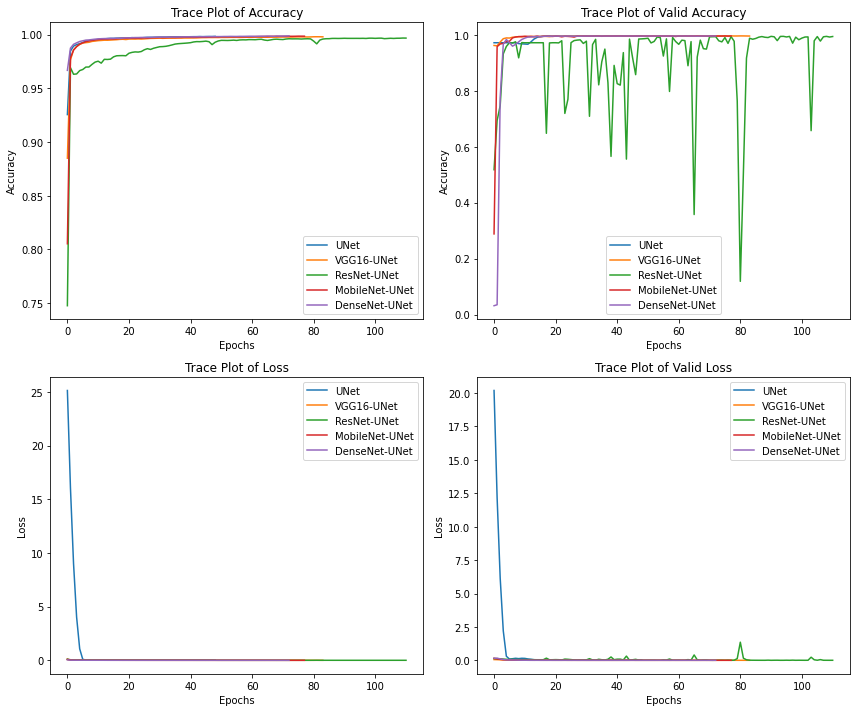

In [38]:
# plot history and accurarcy of both unet and vgg16-unet
plot_curve(unet_history, vgg16_unet_history,resnet_unet_history,mobile_unet_history,dense_unet_history)

In [59]:
class Evaluate:
    # Flatten both matrices at the initial stage.
    def __init__(self, y_test, y_pred, threshold, name):
        self.y_true = y_test.flatten()
        self.y_pred = (y_pred>= threshold).astype('float64').flatten()
        self.y_pred_ori = y_pred.flatten()
        self.name = name
        self.build()

    # Calculate AUC socre
    def AUC(self):
        fpr, tpr, thresholds = roc_curve(self.y_true, self.y_pred_ori)
        auc_score = auc(fpr, tpr)
        return auc_score

    # Calculate True Positive, False Positive, True Negative, False Negative
    def Confusion_matrix(self):
        TP = np.sum((self.y_true == 1) & (self.y_pred == 1)) # True positives  (TP)
        FP = np.sum((self.y_true == 0) & (self.y_pred == 1)) # False positives (FP)
        TN = np.sum((self.y_true == 0) & (self.y_pred == 0)) # True negatives  (TN)
        FN = np.sum((self.y_true == 1) & (self.y_pred == 0)) # False negatives (FN)
        return TP, FP, TN, FN

    # The proportion of predicted positive cases that were correctly identified by the model.
    def Precision(self):
        TP, FP, _, _ = self.Confusion_matrix()
        return TP / (TP + FP + 1e-8)

    # The proportion of actual positive cases that were correctly captured by the model.
    def Recall(self):
        TP, _, _, FN = self.Confusion_matrix()
        return TP / (TP + FN + 1e-8)

    def DSC(self):
        intersection = np.sum(self.y_true * self.y_pred)
        union =  np.sum(self.y_pred) + np.sum(self.y_true)
        dice = (2. * intersection) / (union + 1e-8)   # avoid the denominator as 0
        return dice

    def build(self):
        # Evaluate the model in ROC_AUC, Precision, Recall, DSC (F1-score)
        table = PrettyTable()
        table.field_names = ['Model', 'AUC', 'Recall', 'Precision', 'DSC']
        table.add_row([self.name, round(self.AUC(), 4), round(self.Recall(), 4), round(self.Precision(), 4), round(self.DSC(), 4), ])
        print(table)

In [60]:
arr = np.arange(0, 1, 0.05)
unet_preds = unet.predict(X_test, verbose=1)
vgg16_unet_preds = vgg16_unet.predict(X_test, verbose=1)
resnet_unet_preds = resnet_unet.predict(X_test, verbose=1)
mobile_unet_preds = mobile_unet.predict(X_test, verbose=1)
dense_unet_preds = dense_unet.predict(X_test, verbose=1)

for i in arr:
    print('threshold = ',i)
    Evaluate(y_test, unet_preds,i, 'UNet')
    Evaluate(y_test, vgg16_unet_preds,i, 'VGG16-UNet')
    Evaluate(y_test, resnet_unet_preds,i, 'ResNet-UNet')
    Evaluate(y_test, mobile_unet_preds,i, 'MobileNet-UNet')
    Evaluate(y_test, dense_unet_preds,i, 'DenseNet-UNet')

31/31 [==============================] - 2s 70ms/step
threshold =  0.0
+-------+--------+--------+-----------+--------+
| Model |  AUC   | Recall | Precision |  DSC   |
+-------+--------+--------+-----------+--------+
|  UNet | 0.9993 |  1.0   |   0.0275  | 0.0534 |
+-------+--------+--------+-----------+--------+
+------------+-------+--------+-----------+--------+
|   Model    |  AUC  | Recall | Precision |  DSC   |
+------------+-------+--------+-----------+--------+
| VGG16-UNet | 0.999 |  1.0   |   0.0275  | 0.0534 |
+------------+-------+--------+-----------+--------+
+-------------+--------+--------+-----------+--------+
|    Model    |  AUC   | Recall | Precision |  DSC   |
+-------------+--------+--------+-----------+--------+
| ResNet-UNet | 0.9987 |  1.0   |   0.0275  | 0.0534 |
+-------------+--------+--------+-----------+--------+
+----------------+--------+--------+-----------+--------+
|     Model      |  AUC   | Recall | Precision |  DSC   |
+----------------+--------+-

In [88]:
# Plot UNet vs. VGG16-UNet segmented performance
def plot_result(images, labels, unet_preds, vgg16_unet_preds,resnet_unet_preds,mobile_unet_preds,dense_unet_preds):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Plot the original MRI marks
    axes[0, 0].set_title('Ground Truth')
    axes[0, 0].set_axis_off()

    axes[0, 0].imshow(images, cmap='gray', alpha=0.5)
    axes[0, 0].imshow(labels, cmap='inferno', alpha=0.5)
    # Plot the overlapped (UNet predicted vs true) MRI image
    axes[0, 1].set_title('UNet Segmented Area')
    axes[0, 1].set_axis_off()

    axes[0, 1].imshow(images, cmap='gray', alpha=0.5)
    axes[0, 1].imshow(unet_preds, cmap = 'inferno', alpha=0.5)
    # Plot the overlapped (VGG16-UNet predicted vs true) MRI image
    axes[0, 2].set_title('VGG16-UNet Segmented Area')
    axes[0, 2].set_axis_off()

    axes[0, 2].imshow(images, cmap='gray', alpha=0.5)
    axes[0, 2].imshow(vgg16_unet_preds, cmap = 'inferno', alpha=0.5)
    # Plot the original MRI marks
    axes[1, 0].set_title('ResNet-UNet Segmented Area')
    axes[1, 0].set_axis_off()

    axes[1, 0].imshow(images, cmap='gray', alpha=0.5)
    axes[1, 0].imshow(resnet_unet_preds, cmap='inferno', alpha=0.5)
    # Plot the overlapped (UNet predicted vs true) MRI image
    axes[1, 1].set_title('Mobile-UNet Segmented Area')
    axes[1, 1].set_axis_off()

    axes[1, 1].imshow(images, cmap='gray', alpha=0.5)
    axes[1, 1].imshow(mobile_unet_preds, cmap = 'inferno', alpha=0.5)
    # Plot the overlapped (VGG16-UNet predicted vs true) MRI image
    axes[1, 2].set_title('DenseNet-UNet Segmented Area')
    axes[1, 2].set_axis_off()

    axes[1, 2].imshow(images, cmap='gray', alpha=0.5)
    axes[1, 2].imshow(dense_unet_preds, cmap = 'inferno', alpha=0.5)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()

In [89]:
# Calculate the intersection between predictions and ground truth
unet_union  = (unet_preds * y_test)
# Find the index of Top-3 segmented images for UNet
index = np.argpartition(np.sum(unet_union, axis=(1,2,3)), -3)[-200::10]

127


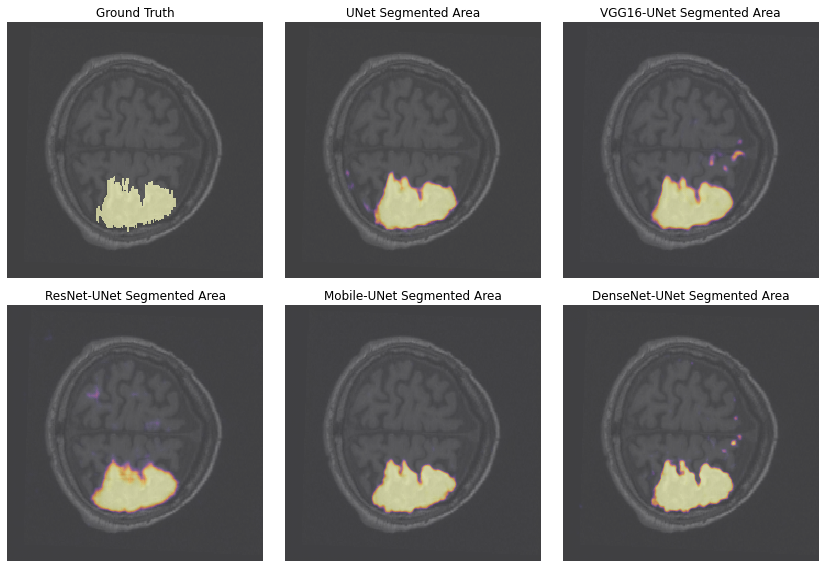

802


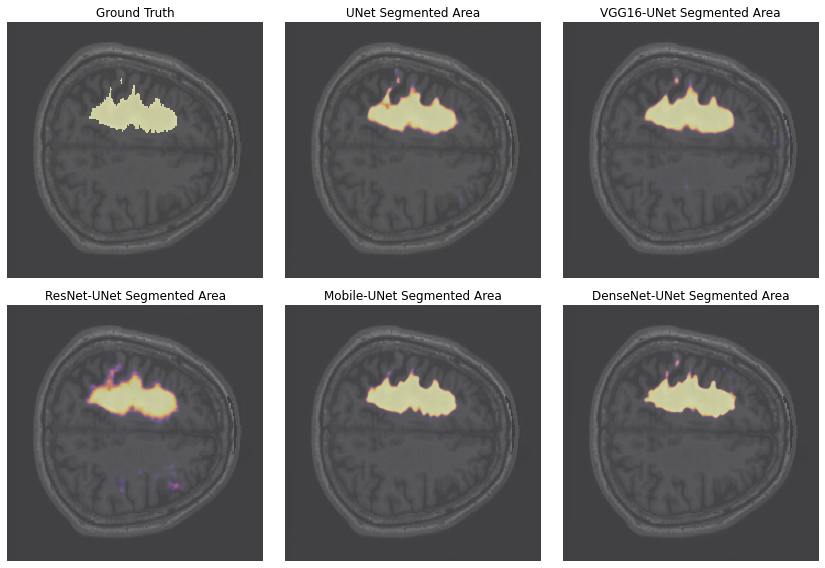

138


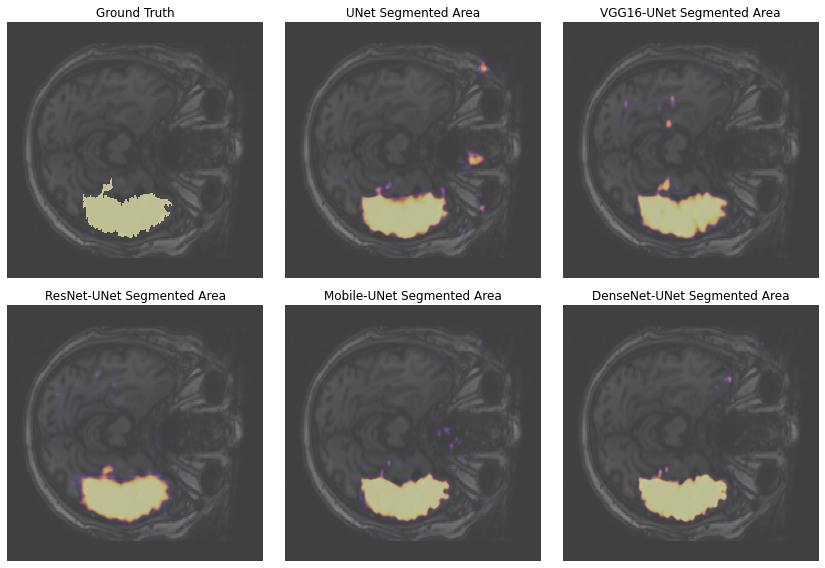

283


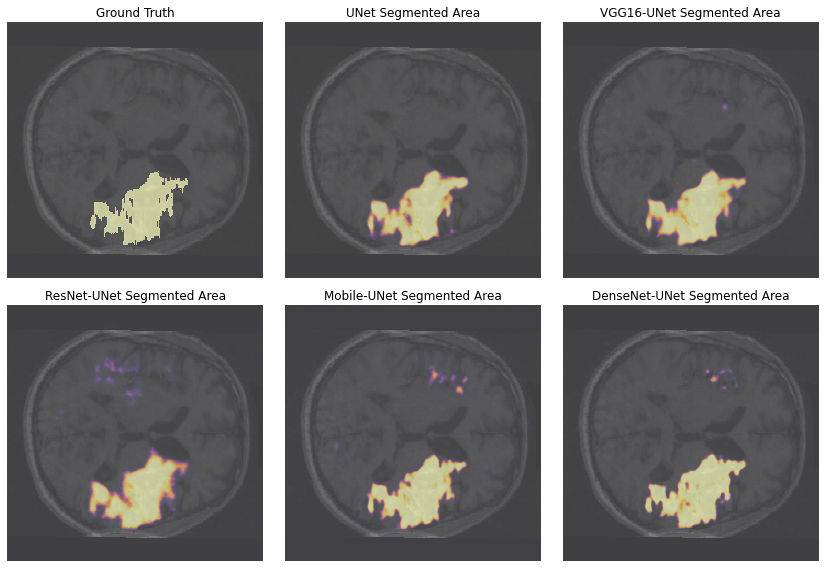

168


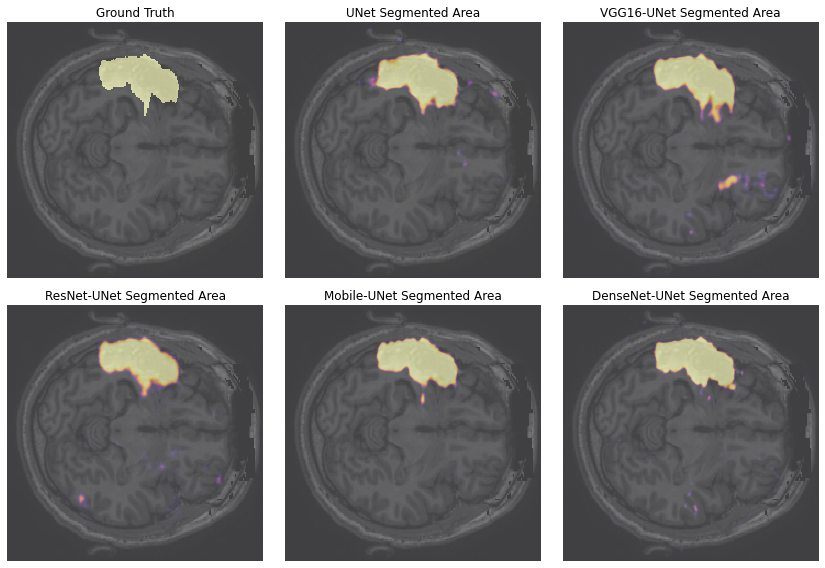

248


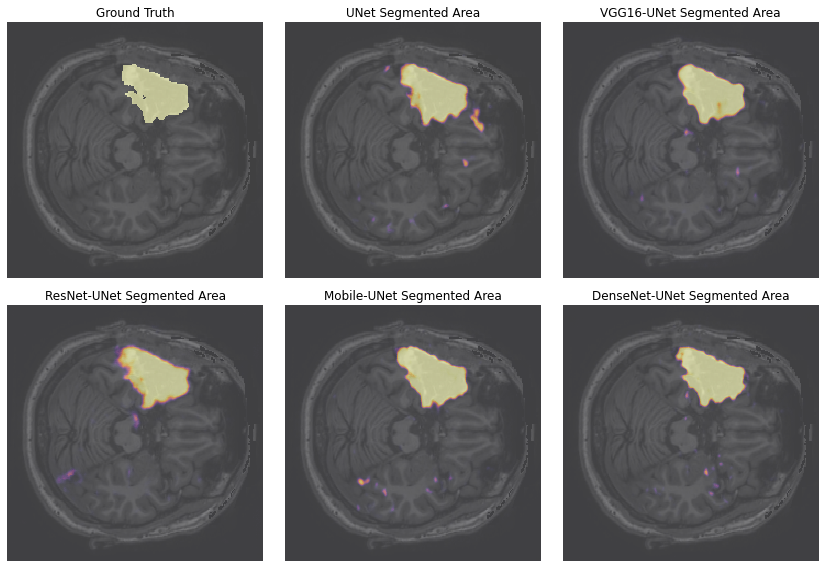

897


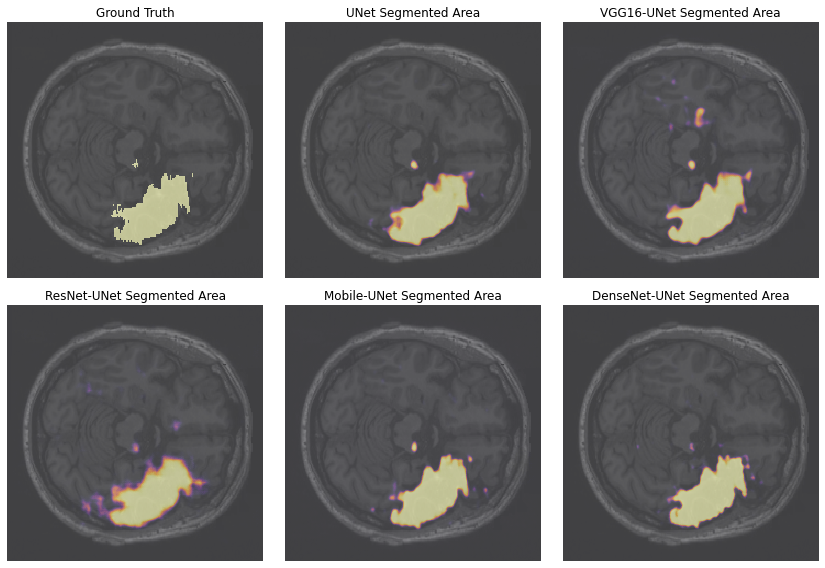

862


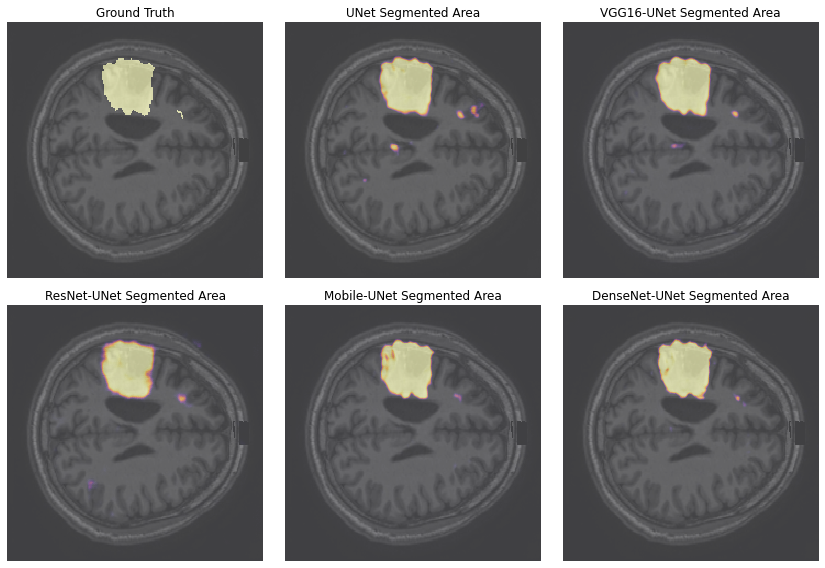

872


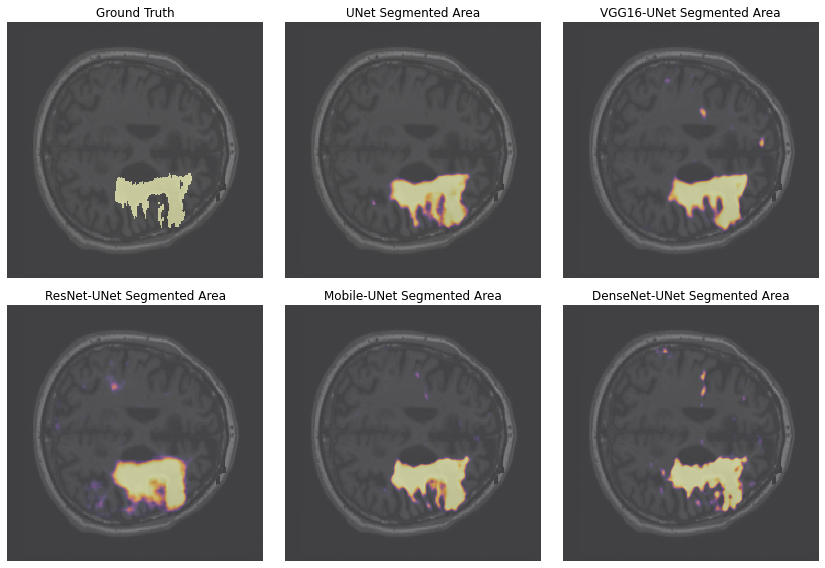

638


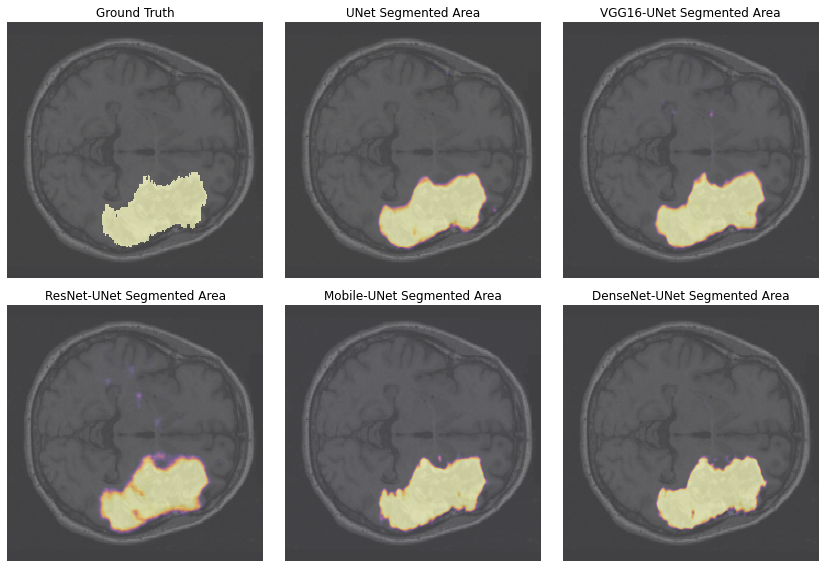

218


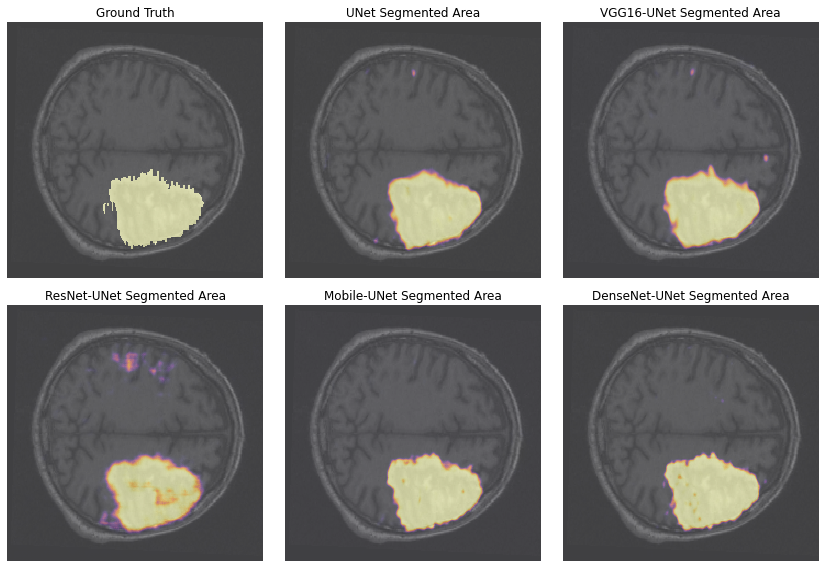

902


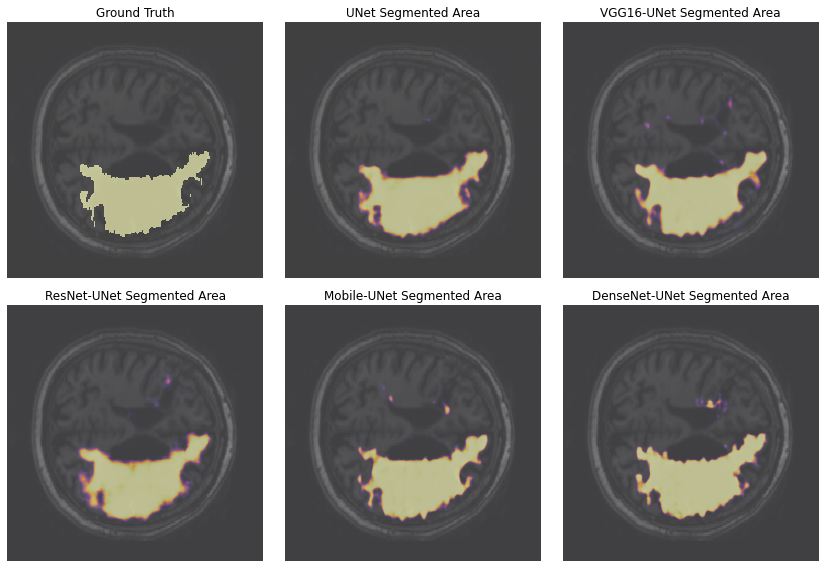

153


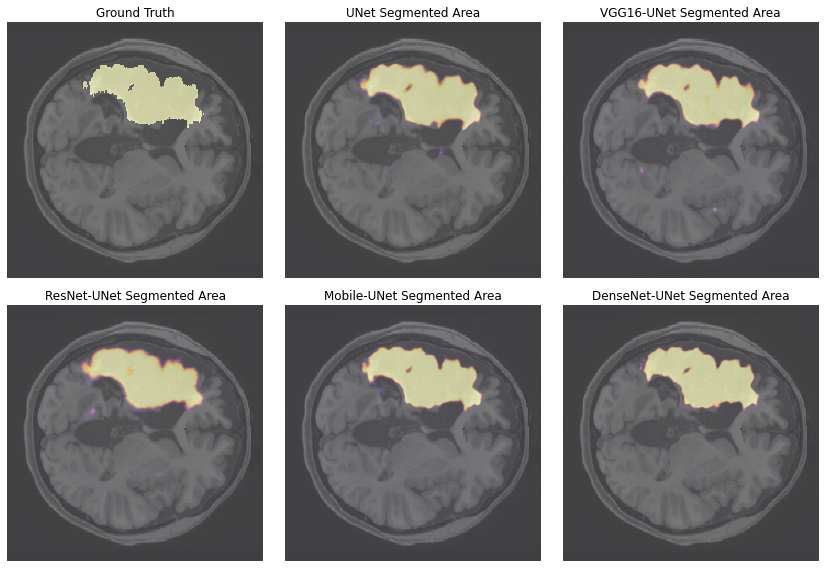

676


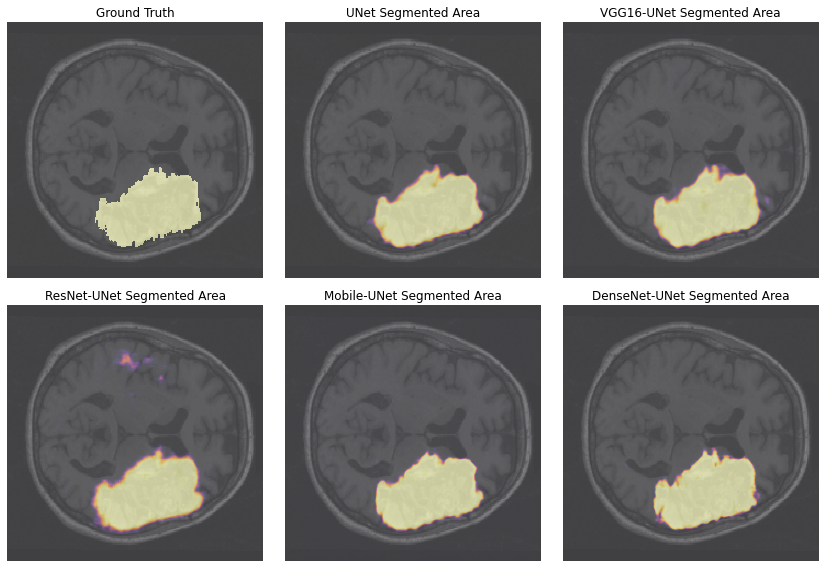

769


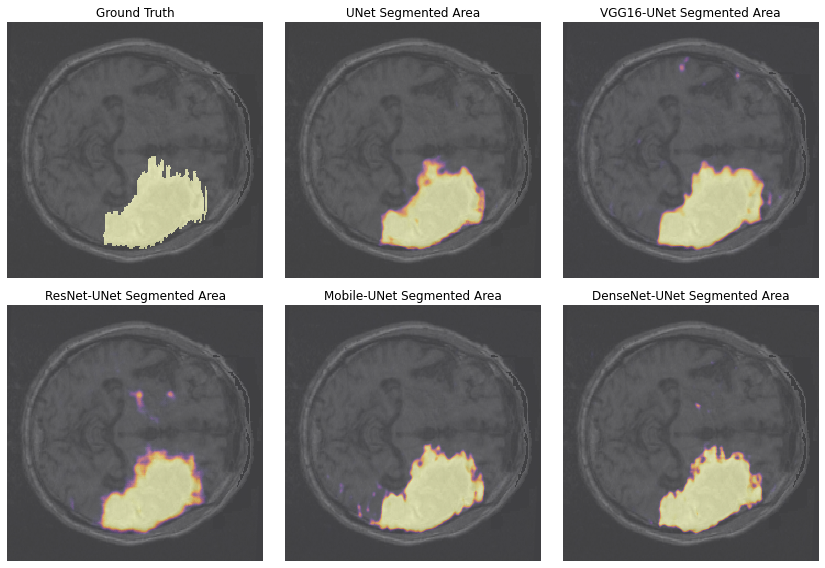

521


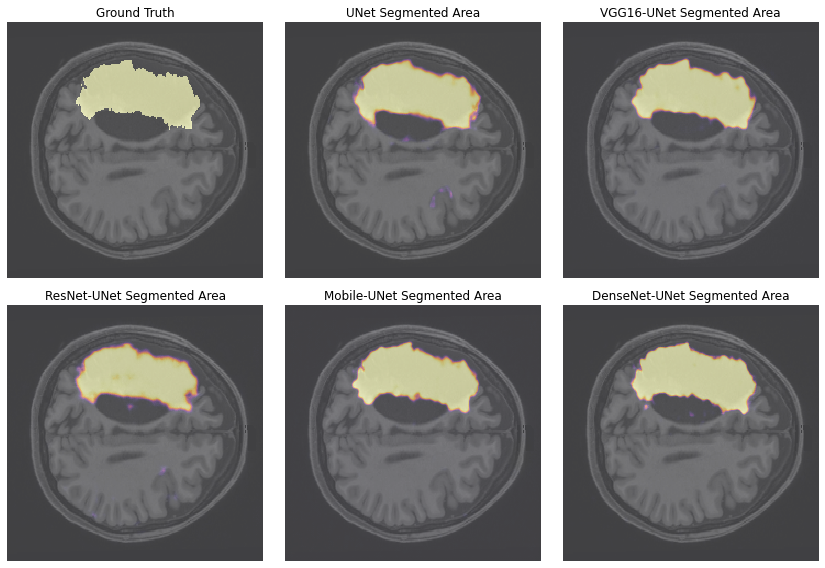

952


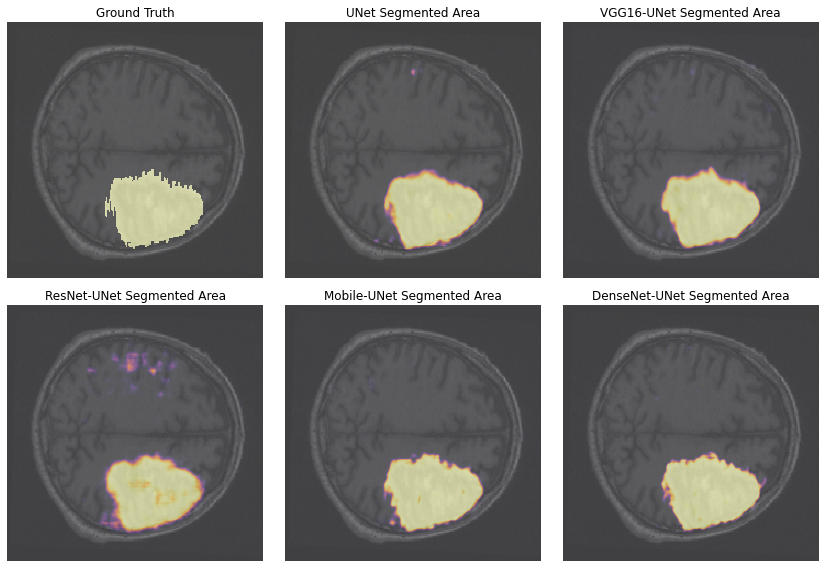

868


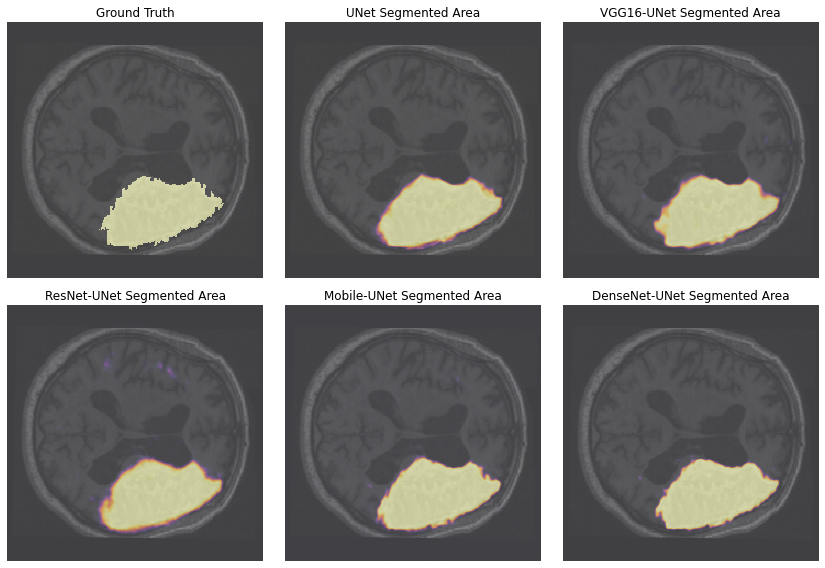

20


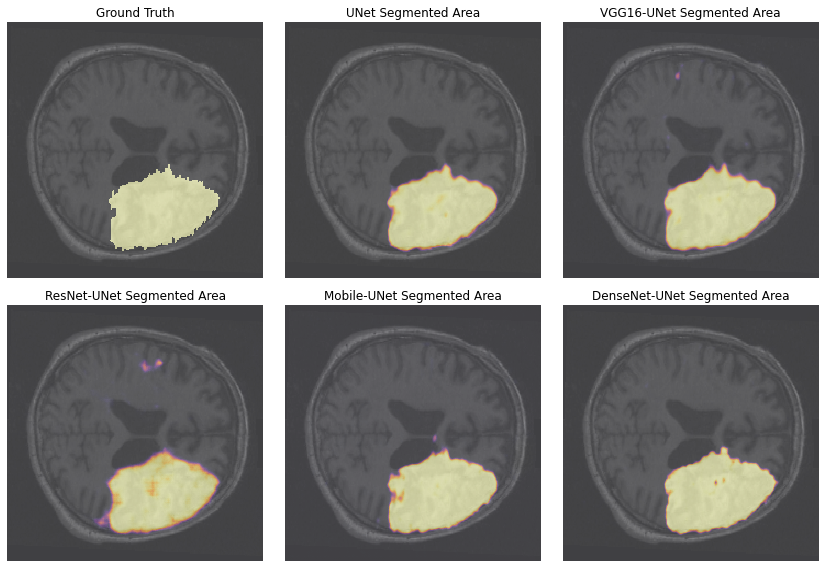

290


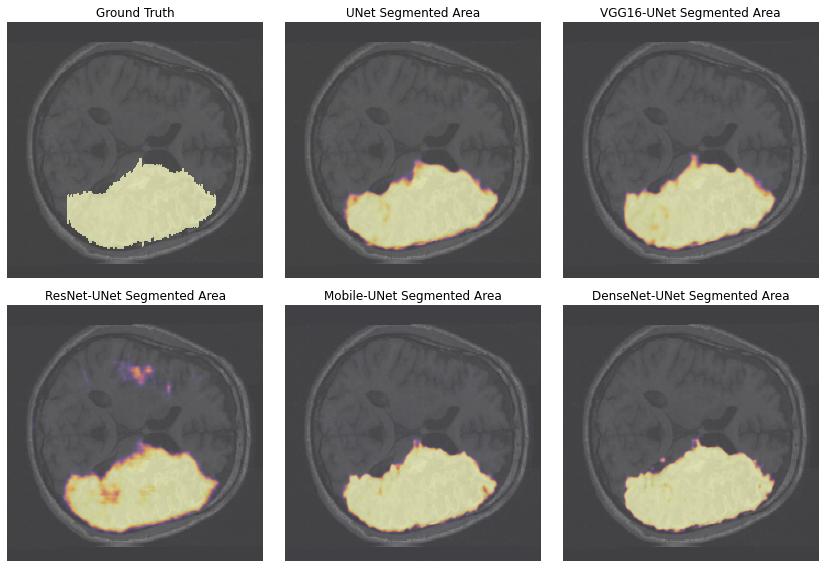

In [90]:
for unnet_index in index:
    print(unnet_index)
    plot_result(X_test[unnet_index], y_test[unnet_index], unet_preds[unnet_index], vgg16_unet_preds[unnet_index],resnet_unet_preds[unnet_index],mobile_unet_preds[unnet_index],dense_unet_preds[unnet_index])

In [55]:
dense_unet.save('model/dense_unet.h5')
mobile_unet.save('model/mobile_unet.h5')
resnet_unet.save('model/resnet_unet.h5')
vgg16_unet.save('model/vgg16_unet.h5')
unet.save('model/unet.h5')

In [56]:
np.save('data/dense_unet_history.npy', dense_unet_history)
np.save('data/mobile_unet_history.npy', mobile_unet_history)
np.save('data/resnet_unet_history.npy', resnet_unet_history)
np.save('data/vgg16_unet_history.npy', vgg16_unet_history)
np.save('data/unet_history.npy', unet_history)

INFO:tensorflow:Assets written to: ram://1848e6ef-84c5-4820-85e8-b22807c13582/assets


INFO:tensorflow:Assets written to: ram://1848e6ef-84c5-4820-85e8-b22807c13582/assets


INFO:tensorflow:Assets written to: ram://bea39919-2cc7-4e38-b192-582afc66ee26/assets


INFO:tensorflow:Assets written to: ram://bea39919-2cc7-4e38-b192-582afc66ee26/assets


INFO:tensorflow:Assets written to: ram://89a43c56-81a8-4fb9-b851-5ef48af7e036/assets


INFO:tensorflow:Assets written to: ram://89a43c56-81a8-4fb9-b851-5ef48af7e036/assets


INFO:tensorflow:Assets written to: ram://8fd3e3b2-b7a9-48e5-a0d3-69eccc4bd51c/assets


INFO:tensorflow:Assets written to: ram://8fd3e3b2-b7a9-48e5-a0d3-69eccc4bd51c/assets


INFO:tensorflow:Assets written to: ram://c75b5198-cc17-4a0a-8284-68bd98e992fd/assets


INFO:tensorflow:Assets written to: ram://c75b5198-cc17-4a0a-8284-68bd98e992fd/assets
